In [1]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import cv2
import seaborn as sns
import re
import contractions

from nltk.corpus import stopwords
from nltk.stem.porter import *
from nltk.sentiment.vader import SentimentIntensityAnalyzer
# additional  = ['rt','rts','retweet'] # lista adicional de stopwords
# swords = set().union(stopwords.words('english'),additional) # adicionando palavras para o stopwords

from tensorflow.keras.layers import Input, Conv2D 
from tensorflow.keras.layers import MaxPool2D, Flatten, Dense 
from tensorflow.keras import Model
import numpy as np
from sklearn.model_selection import train_test_split

In [2]:
path = "C:\\Users\\rbdf\\Documents\\Datasets\\SentimentAnalysis\\dataset_sidi_512.csv"
df512 = pd.read_csv(path, sep='\t')
df512

,Unnamed: 0,Unnamed: 0.1,image_name,NEG,NEU,POS,text,sent_text,sent_image,image_path,image_height,image_width
0,382583,382583,798338609870872577-2,0.774375,0.174701,0.050924,what does it look like i do for a living? (cra...,NEG,0,data/79833/798338609870872577-2.jpg,1280,722
1,443004,443004,802556641057054721-1,0.540009,0.304103,0.155888,No cheat just skill. #ClikerHeroes https://t.c...,NEG,0,data/80255/802556641057054721-1.jpg,707,1366
2,348885,348885,796032212407721984-1,0.513661,0.322456,0.163883,@KEILOin_DaTrunk I deleted https://t.co/qIhBkn...,NEG,0,data/79603/796032212407721984-1.jpg,1334,750
3,377487,377487,798011160532381696-1,0.712648,0.254173,0.033180,"""RT NYTFashion: How Nasty Gal went from an eBa...",NEG,0,data/79801/798011160532381696-1.jpg,561,1000
4,423703,423703,801181521679790080-1,0.713677,0.186854,0.099468,I hate this nigga lmaooo https://t.co/gPcyJfJESN,NEG,0,data/80118/801181521679790080-1.jpg,1334,750
...,...,...,...,...,...,...,...,...,...,...,...,...
11995,108284,108284,769551952275509248-1,0.010517,0.886504,0.102978,RT @Alwas97: find someone who loves you like b...,NEU,1,data/76955/769551952275509248-1.jpg,1218,1078
11996,93186,93186,769486781158858753-1,0.065240,0.897818,0.036942,RT @MelbWritersFest: Helen Garner talking to @...,NEU,1,data/76948/769486781158858753-1.jpg,1491,2048
11997,298145,298145,783915769943973890-1,0.011468,0.925276,0.063257,Watch lesbian movie: https://t.co/jzJrDcnAwaSh...,NEU,1,data/78391/783915769943973890-1.jpg,1024,683
11998,260672,260672,783138720610476033-1,0.003072,0.957911,0.039016,Click here to watch the movie: https://t.co/A...,NEU,1,data/78313/783138720610476033-1.jpg,1024,682


In [3]:
# filenames = ['C:\\Users\\rbdf\\Documents\\Datasets\\t4sa\\' + fname for fname in df512['image_name'].head(1000).tolist()]
# filenames = ['C:\\Users\\rbdf\\Documents\\Datasets\\t4sa\\' + fname for fname in df512['image_path'].head(1000).tolist()]
# labels = df512['sent_image'].head(1000).tolist()
# filenames = ['C:\\Users\\rbdf\\Documents\\Datasets\\t4sa\\' + fname for fname in df512['image_path'].tolist()]
# labels = df512['sent_image'].tolist()


filenames = df512.head(1000)
labels = df512.head(1000)
train_filenames, val_filenames, train_labels, val_labels = train_test_split(filenames,labels, train_size=0.9,random_state=42)

In [4]:
# df512[df512['text'].notna()]


In [5]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# import SentimentIntensityAnalyzer class
# from vaderSentiment.vaderSentiment module.
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
 
# function to print sentiments
# of the sentence.
def sentiment_scores(sentence):
 
    # Create a SentimentIntensityAnalyzer object.
    sid_obj = SentimentIntensityAnalyzer()
 
    # polarity_scores method of SentimentIntensityAnalyzer
    # object gives a sentiment dictionary.
    # which contains pos, neg, neu, and compound scores.
    sentiment_dict = sid_obj.polarity_scores(sentence)
    
    return sentiment_dict['compound']
     
 
    # decide sentiment as positive, negative and neutral
#     if sentiment_dict['compound'] >= 0.05 :
#         return "Positive"
 
#     elif sentiment_dict['compound'] <= - 0.05 :
#          return  "Negative"
 
#     else :
#          return "Neutral"

In [6]:
twText = df512.copy()

In [7]:
twText['text'] = twText['text'].apply(lambda x: re.split('https:\/\/.*', str(x))[0]) # remove urls
twText['text'] = twText['text'].str.replace('\d+', '') # remove valores numericos
twText.astype(str).apply(lambda x: x.str.encode('ascii', 'ignore').str.decode('ascii'))
text = twText['text'][0]
text

C:\Users\rbdf\AppData\Local\Temp/ipykernel_23060/655204127.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  twText['text'] = twText['text'].str.replace('\d+', '') # remove valores numericos


'what does it look like i do for a living? (crave death and rts) '

In [8]:
def tweet_to_words(tweet):
    ''' Convert tweet text into a sequence of words '''
    # convert to lowercase
    text = tweet.lower()
            
    # remove non letters
    text = re.sub("@[A-Za-z0-9_]+","", text) #remove menções
    text = re.sub(r'#[a-zA-z0-9]+','',text) # remove hashtag
    text = re.sub(r"[^a-zA-Z0-9]", " ", text)        
    text = re.sub('[()!?]', ' ', text)
    text = re.sub('\[.*?\]',' ', text)
    text = re.sub("[^a-z0-9]"," ", text)
    text = contractions.fix(text)
    # text = ''.join(c for c in tweet if c not in emoji.UNICODE_EMOJI)
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)
    # tokenize
    words = text.split()
    # remove stopwords
    words = [w for w in words if w not in stopwords.words("english")]
    # apply stemming
    # words = [PorterStemmer().stem(w) for w in words]
    # return list
    return words

In [9]:
twText['cleantext']=twText['text'].map(lambda x: tweet_to_words(x))
twText

,Unnamed: 0,Unnamed: 0.1,image_name,NEG,NEU,POS,text,sent_text,sent_image,image_path,image_height,image_width,cleantext
0,382583,382583,798338609870872577-2,0.774375,0.174701,0.050924,what does it look like i do for a living? (cra...,NEG,0,data/79833/798338609870872577-2.jpg,1280,722,"[look, like, living, crave, death, rts]"
1,443004,443004,802556641057054721-1,0.540009,0.304103,0.155888,No cheat just skill. #ClikerHeroes,NEG,0,data/80255/802556641057054721-1.jpg,707,1366,"[cheat, skill]"
2,348885,348885,796032212407721984-1,0.513661,0.322456,0.163883,@KEILOin_DaTrunk I deleted,NEG,0,data/79603/796032212407721984-1.jpg,1334,750,[deleted]
3,377487,377487,798011160532381696-1,0.712648,0.254173,0.033180,"""RT NYTFashion: How Nasty Gal went from an eBa...",NEG,0,data/79801/798011160532381696-1.jpg,561,1000,"[rt, nytfashion, nasty, gal, went, ebay, page,..."
4,423703,423703,801181521679790080-1,0.713677,0.186854,0.099468,I hate this nigga lmaooo,NEG,0,data/80118/801181521679790080-1.jpg,1334,750,"[hate, nigga, lmaooo]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11995,108284,108284,769551952275509248-1,0.010517,0.886504,0.102978,RT @Alwas: find someone who loves you like bra...,NEU,1,data/76955/769551952275509248-1.jpg,1218,1078,"[rt, find, someone, loves, like, brad, loves, ..."
11996,93186,93186,769486781158858753-1,0.065240,0.897818,0.036942,RT @MelbWritersFest: Helen Garner talking to @...,NEU,1,data/76948/769486781158858753-1.jpg,1491,2048,"[rt, helen, garner, talking, difficulty, burni..."
11997,298145,298145,783915769943973890-1,0.011468,0.925276,0.063257,Watch lesbian movie:,NEU,1,data/78391/783915769943973890-1.jpg,1024,683,"[watch, lesbian, movie]"
11998,260672,260672,783138720610476033-1,0.003072,0.957911,0.039016,Click here to watch the movie:,NEU,1,data/78313/783138720610476033-1.jpg,1024,682,"[click, watch, movie]"


In [10]:
sentimental = [sentiment_scores(i) for i in twText['cleantext']]

twText["Sentimento"] = sentimental
twText["Sentimento"]

0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
11995    0.0
11996    0.0
11997    0.0
11998    0.0
11999    0.0
Name: Sentimento, Length: 12000, dtype: float64

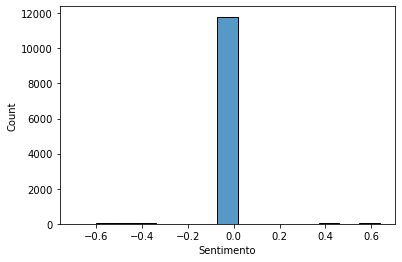

In [11]:
sns.histplot(data = twText["Sentimento"]);

In [23]:
# set(df512["Sentimento"])
# df512["Sentimento"].unique()

In [24]:
# category = ['Negativo','Neutro','Positivo']
# df512['Discrete_Sent'] = pd.cut(df512['Sentimento'], bins=[-1,-0.05,0.05,1], labels=category)
# df

TypeError: '<' not supported between instances of 'float' and 'str'